# Fine-Tuning Hands-on

## Importing The Libraries

In [2]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Loading Dataset
we use transformation for the train and test sets  
it's a good practice to augment the train data to make the model more robust to unseen data  
but at the time of testing we can just use the original cifar dataset without any augmentation


In [3]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms_train = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)
data_transforms_test = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=data_transforms_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=data_transforms_test
)

class_names = train_dataset.classes

Files already downloaded and verified
Files already downloaded and verified


## Creating DataLoaders
Generate PyTorch DataLoaders for the training and testing sets, configuring them with the desired parameters.

In [4]:
from multiprocessing import cpu_count

batch_size = 64
shuffle = True
num_workers = cpu_count() - 2

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers
)

In [5]:
from easydict import EasyDict

datasets = EasyDict(
    {
        "train": train_dataset,
        "val": test_dataset,
    }
)
data_loaders = EasyDict(
    {
        "train": train_loader,
        "val": test_loader,
    }
)

## Showing Some Images From The Dataset
Display a selection of images from the dataset. Due to the normalization step in the data transformation, it is necessary to denormalize the images before showing them. To achieve this, we must first convert the tensor to a numpy array and adjust the image channels since the representation of images differs between PyTorch tensors and numpy ndarrays.

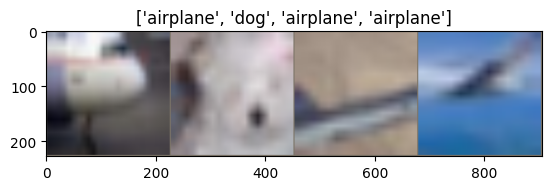

In [6]:
def imshow(img, title=None, ax=None):
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    if ax is None:
        plt.imshow(img)
        if title is not None:
            plt.title(title)
    else:
        ax.imshow(img)
        if title is not None:
            ax.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data and choose a small sample from the batch
imgs, classes = next(iter(data_loaders.train))
imgs = imgs[:4]
classes = classes[:4]

# Make a grid from batch
out = torchvision.utils.make_grid(imgs)

# show each image with the corresponding label
imshow(out, title=[class_names[x] for x in classes])

## Defining The Train Function
In this section, we define the training function which comprises two distinct phases: "train" and "val" (validation). During the "train" phase, the model is trained, while in the "val" phase, we assess the model's accuracy by evaluating it on the validation set.


In [9]:
acc_list = EasyDict({"train": [], "val": []})
loss_list = EasyDict({"train": [], "val": []})


def train_model(model, criterion, optimizer, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs + 1):
        print(f"Epoch {epoch}/{num_epochs}:")

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            loop_iter = tqdm(
                enumerate(data_loaders[phase], 0),
                total=len(data_loaders[phase]),
                leave=False,
                position=1,
            )

            running_loss = 0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in loop_iter:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, predictions = torch.max(outputs, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

                # show the detail in the progress bar
                loop_iter.set_postfix(
                    {
                        "epoch": epoch,
                        "phase": phase,
                        "loss": f"{running_loss / (i+1):04.4f}",
                    }
                )

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.double() / len(datasets[phase])

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # deep copy the model if the founded weight are better than the previous one
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print("Best model updated", end="")

            print()

            # save the loss and accuracy for each epoch
            acc_list[phase].append(epoch_acc)
            loss_list[phase].append(epoch_loss)
        print()
        print()

    print(f"Best val Acc: {best_acc:4f}")

    # load best model weights
    print("Loading model best weights")
    model.load_state_dict(best_model_wts)
    return model

## Transfer Learning

Transfer learning allows us to take the weights of another model has learned from another problem and use them for our own problem.

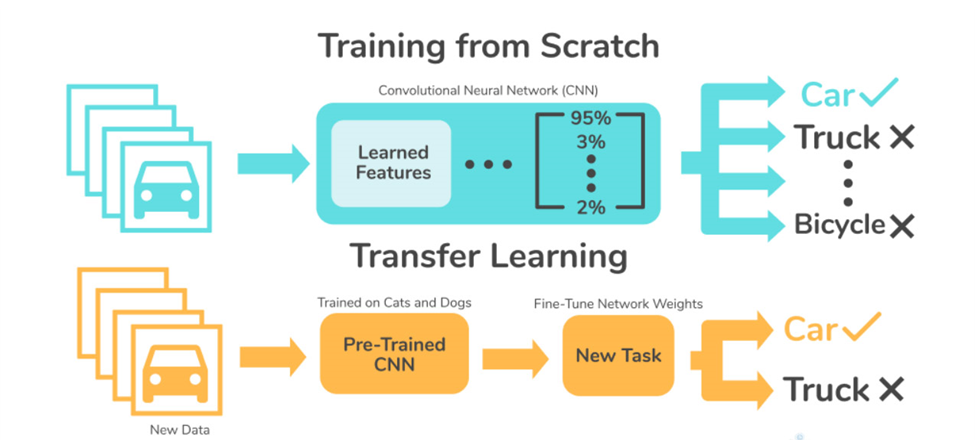
<hr>

There are two main benefits to using transfer learning:
* Can leverage an existing model (usually a neural network architecture) proven to work on problems similar to our own.
* Can leverage a working model which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.  


The fine-tuning will only require a limited amount of data: the knowledge the pretrained model has acquired is “transferred,” hence the term transfer learning.


We perform an analysis of the transfer learning setting for Vision Transformer. In fact, across a wide range of datasets, even if the downstream data of interest appears to only be weakly related to the data used for pre-training, transfer learning remains the best available option.

## Defining The Model

<h3><center>Transformer Architecture</center></h3>
<img src=" 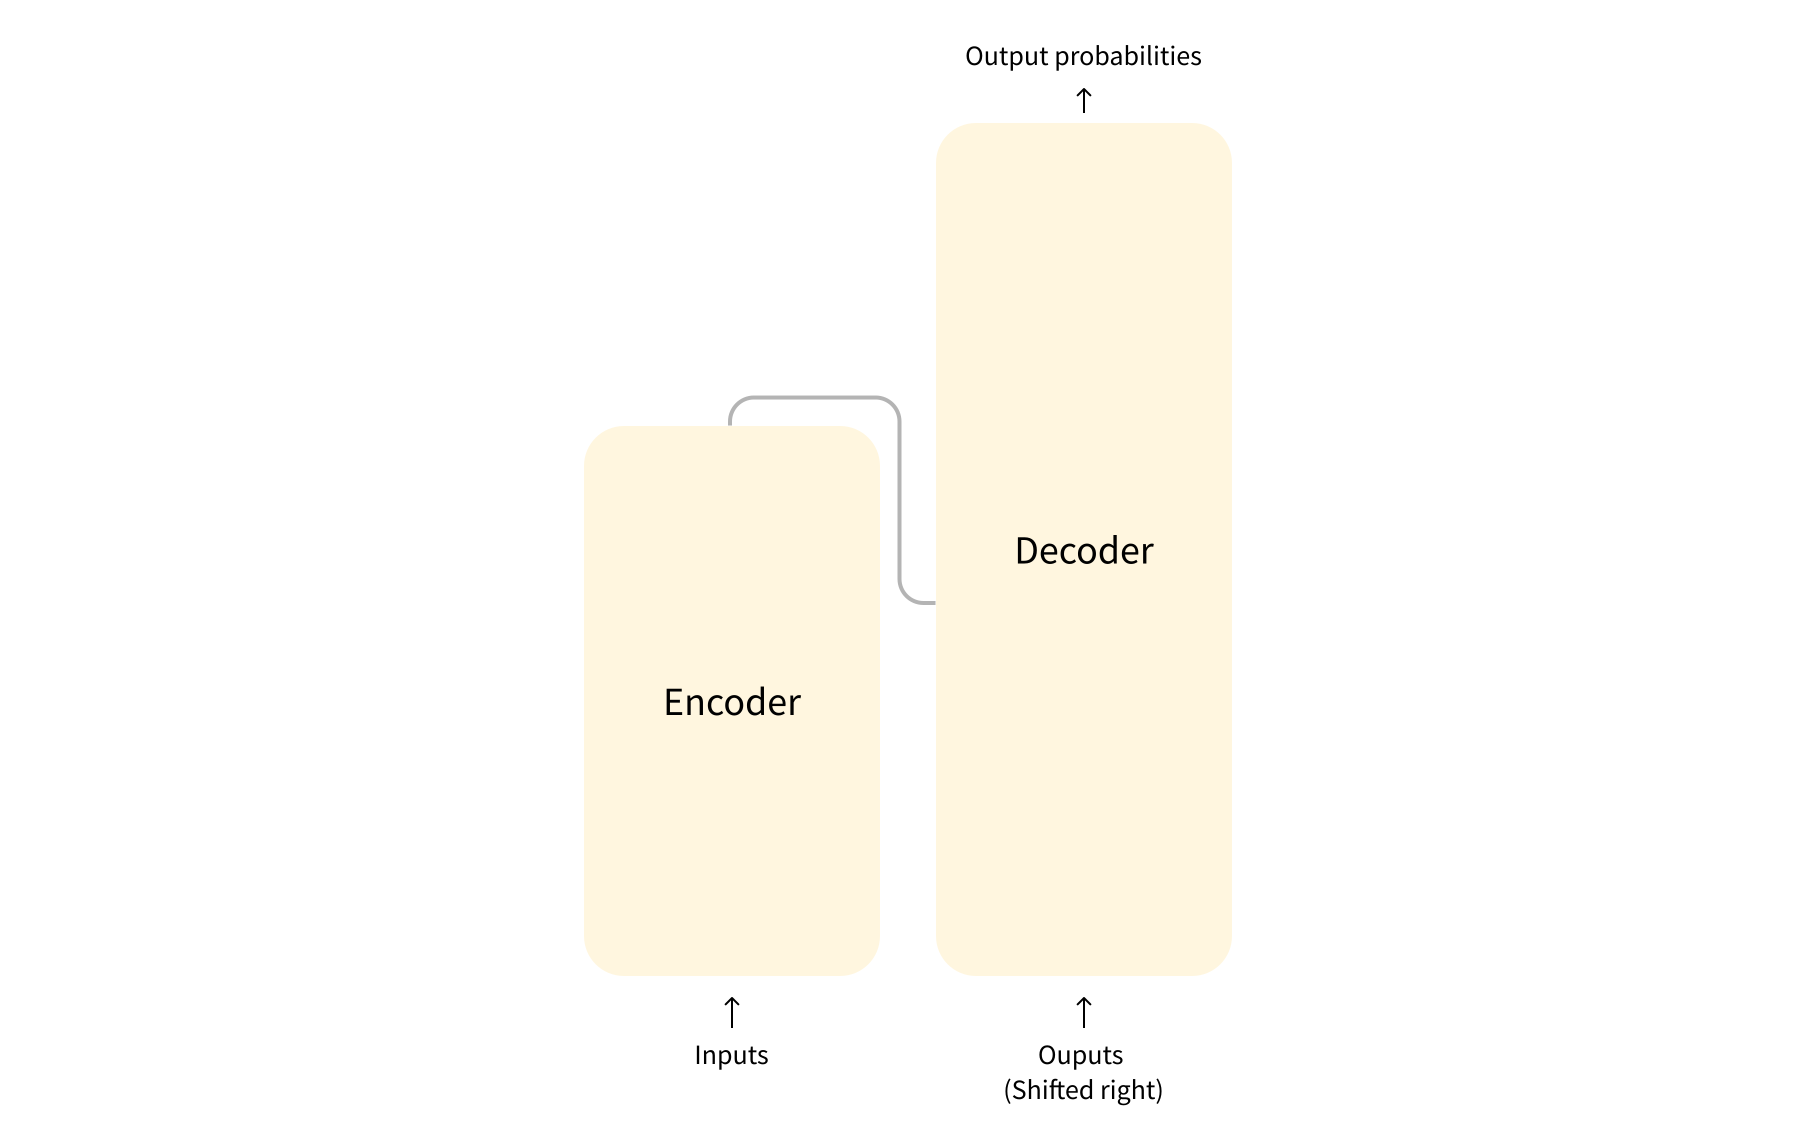" alt="transformer_architecture" style="display: block; margin-left: auto; margin-right: auto; width: 50%">
<hr>

<h3><center>Vision TransFormer (Vit)</center></h3>

<center>
Vision Transformer (ViT) is a simple, efficient architecture based solely on attention mechanisms. It replaces the standard convolutions with multi-head self-attention in a sequential manner. The input image is first split into fixed-size patches, which are then flattened and linearly embedded. The resulting sequence of vectors is then processed by a standard Transformer encoder. The final output of the Transformer is then fed into a standard classification head. The architecture is illustrated in the figure below.
</center>
<img src=" 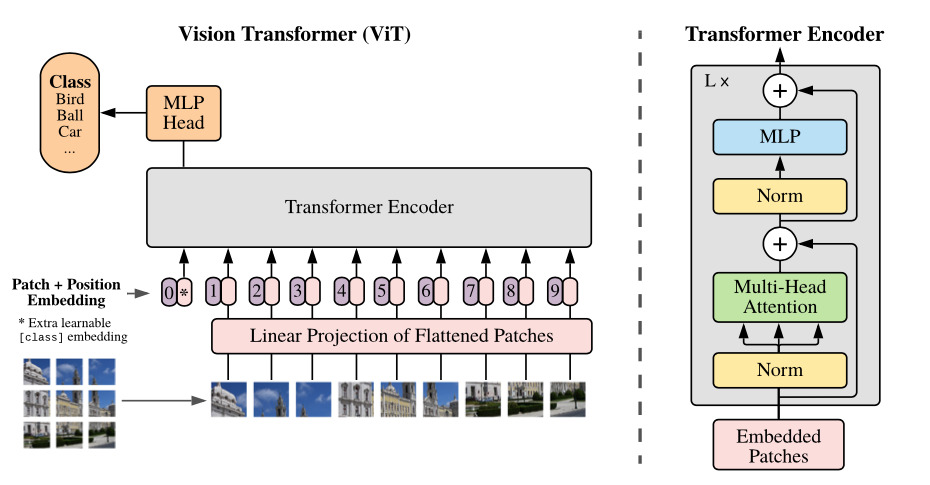" alt="vit" style="display: block; margin-left: auto; margin-right: auto; width: 50%">
<hr>


<h3><center>CNN vs Transformer</center></h3>
<img src=" 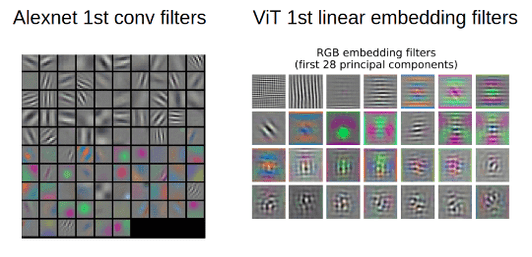" alt="conv-vs-transformer" style="display: block; margin-left: auto; margin-right: auto; width: 50%">




Here we use Visions Transformer (base variant with 32x32 patch) model for the classification task.
the pretrained model is available in the torchvision package.
weights use for the model is "imagenet1k" which is trained on imagenet1k.

In [8]:
model = torchvision.models.vit_b_32(
    weights=torchvision.models.vision_transformer.ViT_B_32_Weights.DEFAULT  # IMAGENET1K_V1
)

since we don't want to update the weights of the model we set the requires_grad attribute of the model to False.

<img src=" 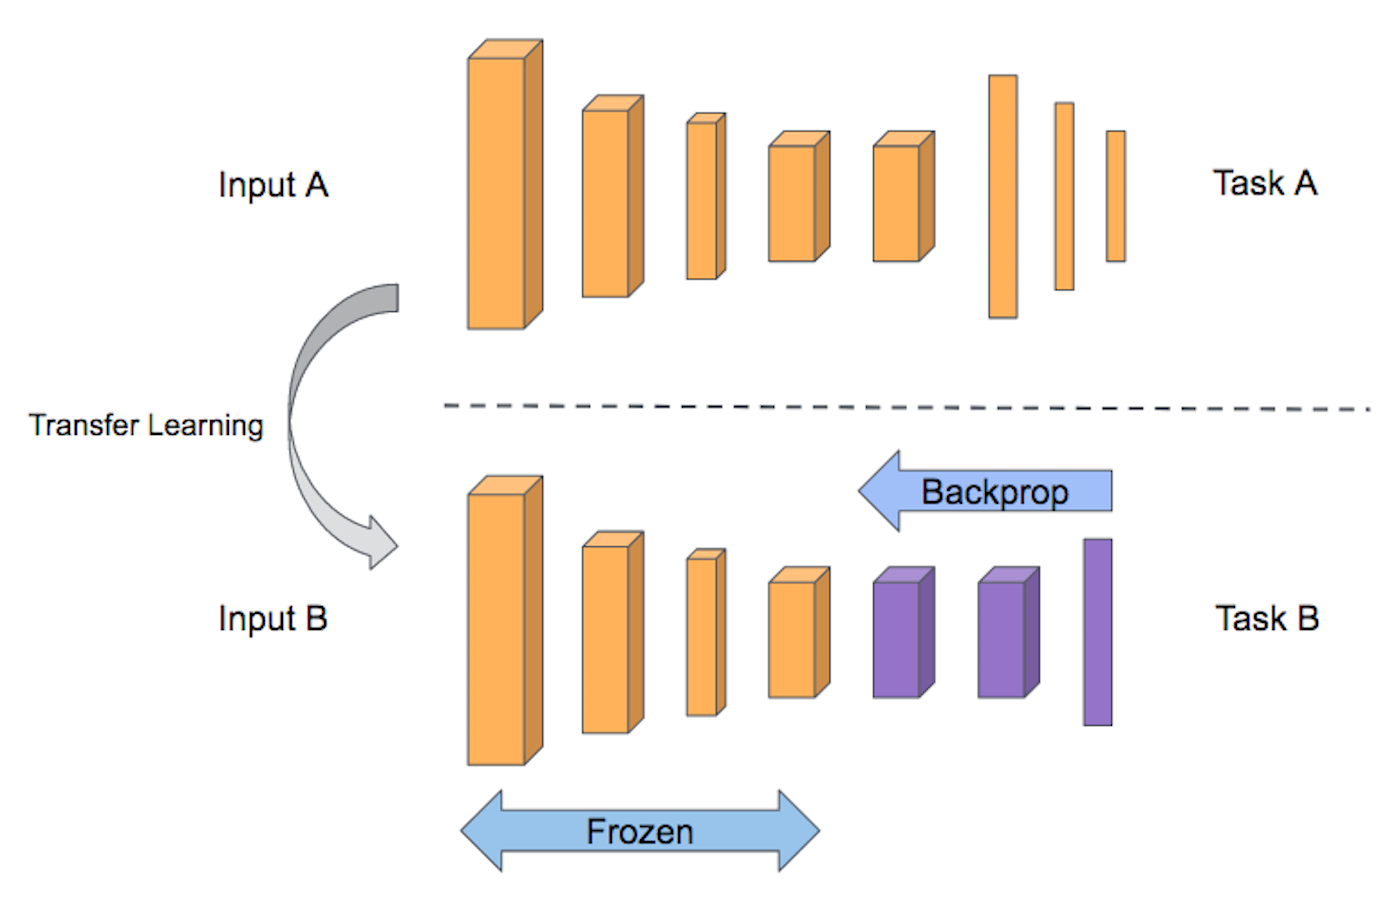" alt="frozen_layers" style="display: block; margin-left: auto; margin-right: auto; width: 50%">


In [9]:
for param in model.parameters():
    param.requires_grad = False


## Replacing the Model Head
here we want to change the head to classify the cifar10 dataset.
The original head is a nn.Linear with 1000 output features,
but we want to change it to a nn.Linear with 10 output features.  
so we define a new head for the model and replace the original head with it.
the new head grad is set to `true` by default and the training phase will
adjust its's weights to minimize the loss function.

last layer of the model is a linear layer with 768 in features and 1000 output neurons.

In [10]:
model.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [11]:
last_layer_in_feature = model.heads[-1].in_features


cifar_last_layer = nn.Sequential(
    nn.BatchNorm1d(last_layer_in_feature),
    nn.Dropout(p=0.25),
    nn.Linear(in_features=last_layer_in_feature, out_features=250),
    nn.ReLU(),
    nn.BatchNorm1d(250, eps=1e-05, momentum=0.1),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=250, out_features=len(class_names)),
)

model.heads = cifar_last_layer

## Defining the Optimizer and Loss Function
we use the cross entropy loss for the classification task and SGD optimizer for the backpropagation phase.  


In [2]:
from torch import optim

model = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# train the model
model = train_model(model, criterion, optimizer, num_epochs=10)


Epoch 1/10:    
                                                                                 
train Loss: 0.8071 Acc: 0.7286
                                                                                   val Loss: 0.2475 Acc: 0.9217 | Best model updated 

Epoch 2/10:                                                                          

train Loss: 0.6507 Acc: 0.7809
                                                                                   
val Loss: 0.2185 Acc: 0.9293 | Best model updated
 
Epoch 3/10:                                                                          

train Loss: 0.6129 Acc: 0.7909
                                                                          
val Loss: 0.2051 Acc: 0.9334 | Best model updated

Epoch 4/10:
                                                                                    
train Loss: 0.5966 Acc: 0.7971
                                                                    
val Loss: 0.2037 Acc: 0.9331

Epoch 5/10

# Evaluating The Model

## Accuracy Plot

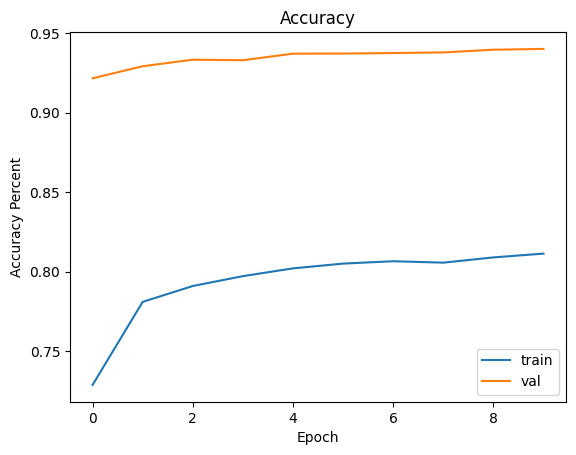

In [3]:
import matplotlib.pyplot as plt
plt.plot([a.cpu() for a in acc_list.train], label="train")
plt.plot([a.cpu() for a in acc_list.val], label="val")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy Percent")
plt.legend()
plt.show()


## Loss Plot

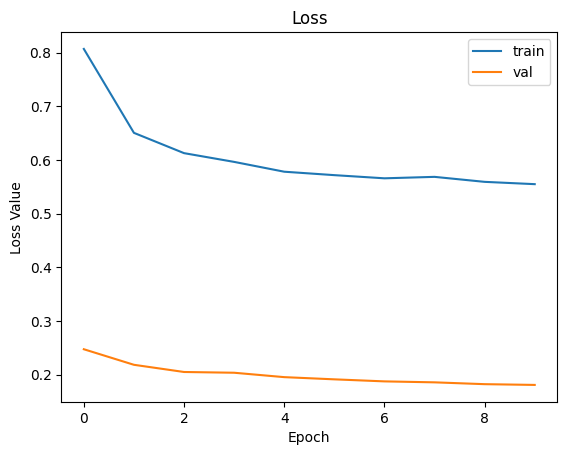

In [57]:
plt.plot([a.cpu() for a in loss_list.train], label="train")
plt.plot([a.cpu() for a in loss_list.val], label="val")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.legend()
plt.show()

## Confusion Matrix

In [15]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn


def plot_cm(model):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(data_loaders.val, leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output)

            labels = labels.data.cpu().numpy()
            y_true.extend(labels)

    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(
        cm / np.sum(cm, axis=1)[:, None],
        index=[i for i in class_names],
        columns=[i for i in class_names],
    )

    plt.figure(figsize=(15, 10))
    sn.heatmap(df_cm, annot=True, cbar=False)
    plt.show()

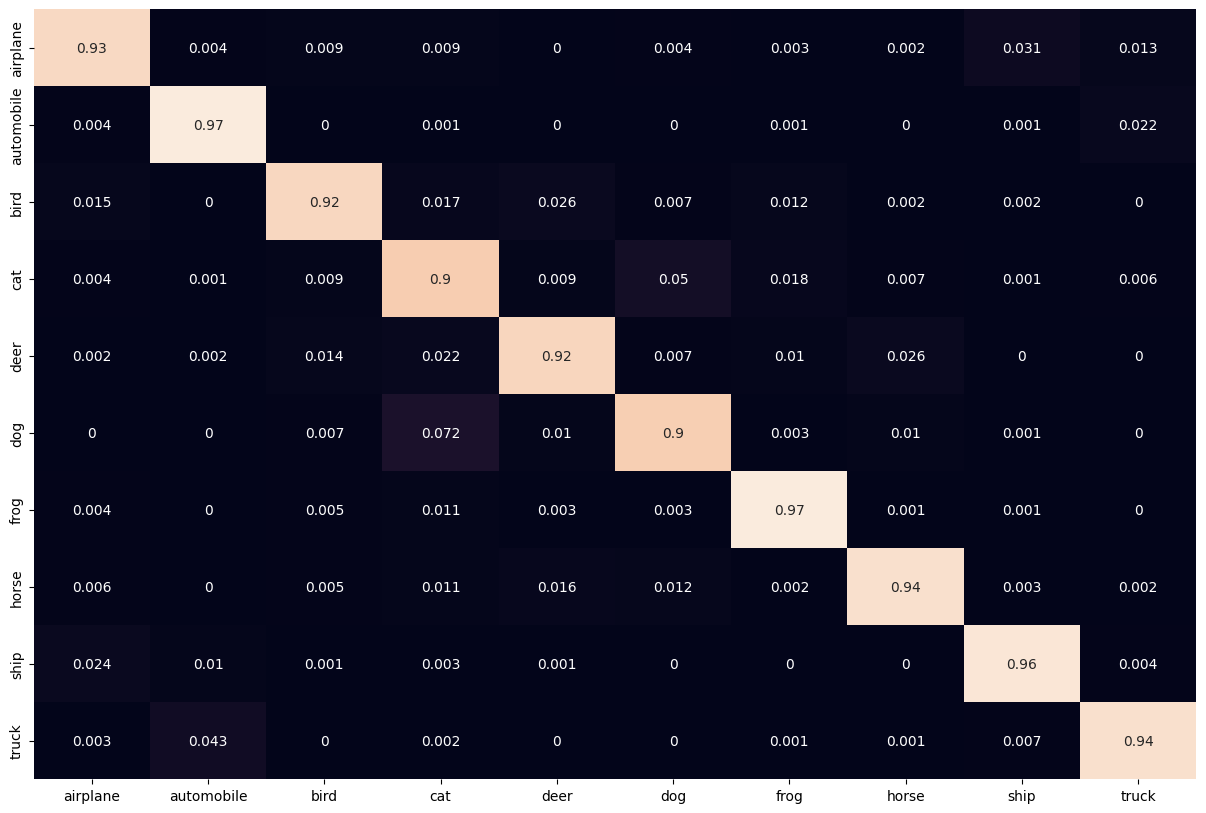

In [16]:
plot_cm(model)

## Visualize The Model Prediction

In [29]:
def visualize_model(model):
    model.eval()
    nrows, ncols = 4, 4
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                img = inputs.cpu().data[j]
                img = img.numpy().transpose((1, 2, 0))
                img = std * img + mean
                img = np.clip(img, 0, 1)
                axes[i][j].axis("off")
                axes[i][j].set_title(
                    f"predicted: {class_names[predictions[j]]}, label: {class_names[labels[j]]}"
                )
                axes[i][j].imshow(img)
                if j == ncols - 1:
                    break
            if i == nrows - 1:
                break

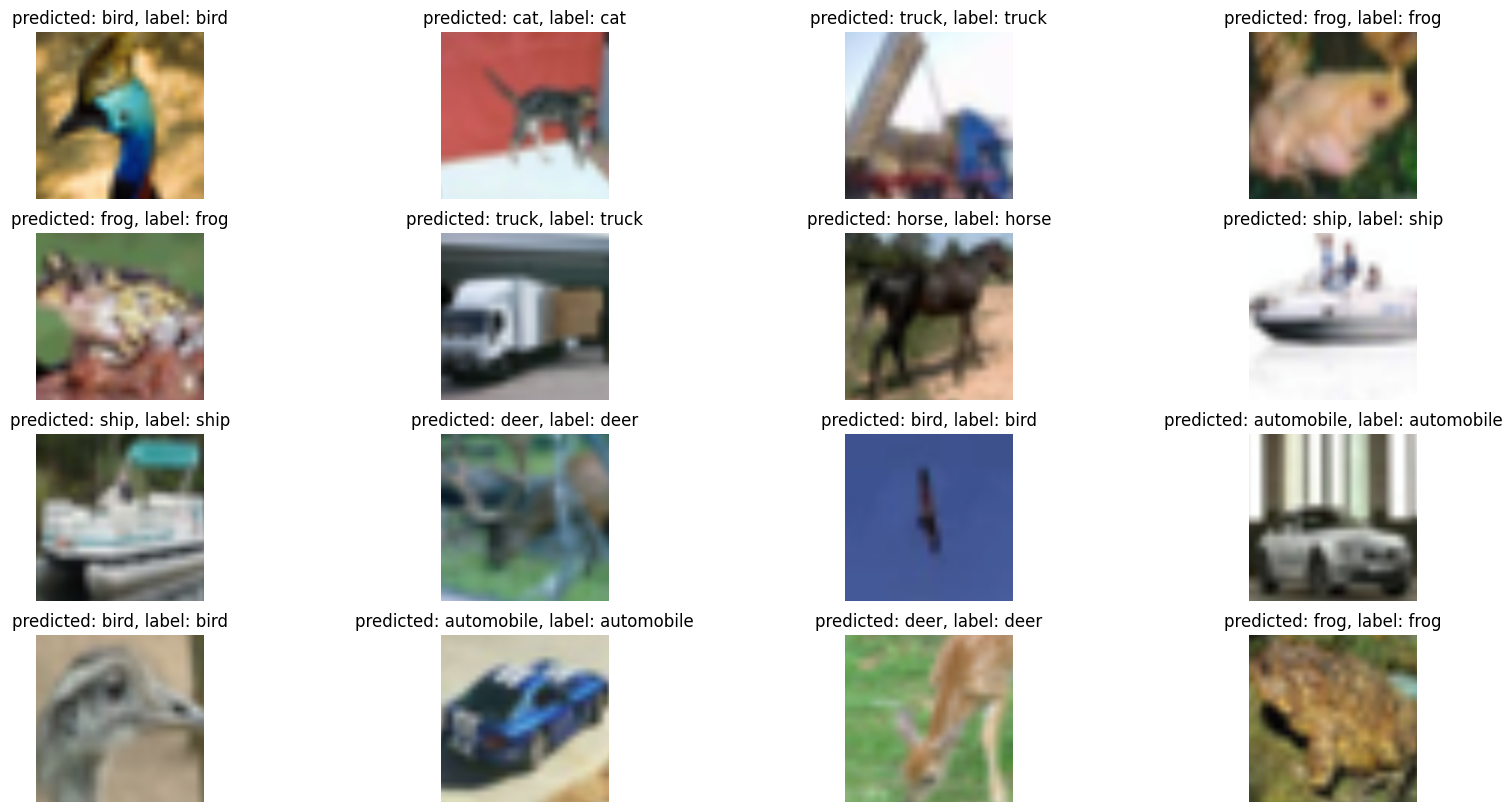

In [30]:
visualize_model(model)